In [1]:
from portfolio_optimization.data_processing import *
from portfolio_optimization.data_collection import *
from datetime import datetime, timezone, timedelta
from tokens.get_assets import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pypfopt
from pypfopt import risk_models, plotting

In [2]:
asset_list = get_tickers()
df = get_historical_prices_for_assets(asset_list['high_risk_tickers'], time_range=timedelta(days=365 * 3))
# Print comprehensive statistical summary
df

High risk tickers: 15
Medium risk tickers: 60
Low risk tickers: 8


,aave,ada,avax,btc,cake,dot,eth,link,matic,sol,uni,bnb,wbtc
2020-07-20,NaN,0.124229,NaN,9218.842311,NaN,NaN,239.358146,8.081399,0.021281,0.923665,NaN,18.029131,9388.378291
2020-07-21,NaN,0.117977,NaN,9167.190568,NaN,NaN,236.361256,7.274300,0.021755,0.873413,NaN,17.545356,9425.893169
2020-07-22,NaN,0.123055,NaN,9388.574350,NaN,NaN,245.250595,7.297541,0.021265,0.977347,NaN,17.742509,11268.006679
2020-07-23,NaN,0.124206,NaN,9531.257430,NaN,NaN,264.199169,7.485817,0.021206,1.041784,NaN,18.018131,11268.006679
2020-07-24,NaN,0.124161,NaN,9609.166715,NaN,NaN,275.223813,7.895025,0.021143,1.057659,NaN,18.714059,10016.670061
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-16,78.923740,0.325887,14.820432,30290.890596,1.541389,5.426049,1930.717785,6.915486,0.798559,27.395074,5.797465,251.135605,30291.136216
2023-07-17,76.798893,0.314830,14.285089,30249.772966,1.506001,5.308692,1924.546247,6.615660,0.769067,27.369360,5.722638,243.016990,30258.854090
2023-07-18,75.178325,0.312459,14.418348,30143.746274,1.548822,5.298416,1912.286380,7.206463,0.778827,26.870350,5.917777,244.155672,30143.746274
2023-07-19,72.019897,0.306693,13.774274,29835.747408,1.509685,5.177132,1897.399071,6.922395,0.737421,25.506394,5.893603,240.082671,29857.411175


,aave,ada,avax,btc,cake,dot,eth,link,matic,sol,uni,bnb,wbtc
aave,1.000000,0.801299,0.330689,0.823072,0.923674,0.864420,0.586910,0.935713,0.216306,0.340938,0.953679,0.462251,0.823090
ada,0.801299,1.000000,0.580950,0.825520,0.848180,0.852745,0.838438,0.775243,0.613089,0.723064,0.831287,0.725492,0.825622
avax,0.330689,0.580950,1.000000,0.661932,0.301132,0.625495,0.828551,0.410891,0.736287,0.890439,0.342243,0.712173,0.661920
btc,0.823072,0.825520,0.661932,1.000000,0.775975,0.936932,0.846529,0.813552,0.512981,0.668610,0.838471,0.733781,0.999907
cake,0.923674,0.848180,0.301132,0.775975,1.000000,0.830873,0.648185,0.933188,0.246401,0.407851,0.939702,0.714653,0.775857
dot,0.864420,0.852745,0.625495,0.936932,0.830873,1.000000,0.774502,0.910102,0.423699,0.669922,0.894637,0.664495,0.937112
eth,0.586910,0.838438,0.828551,0.846529,0.648185,0.774502,1.000000,0.593206,0.838564,0.874682,0.629506,0.908684,0.846152
link,0.935713,0.775243,0.410891,0.813552,0.933188,0.910102,0.593206,1.000000,0.238050,0.439343,0.935338,0.468356,0.814383
matic,0.216306,0.613089,0.736287,0.512981,0.246401,0.423699,0.838564,0.238050,1.000000,0.763339,0.287509,0.837583,0.512155
sol,0.340938,0.723064,0.890439,0.668610,0.407851,0.669922,0.874682,0.439343,0.763339,1.000000,0.392693,0.740910,0.668726


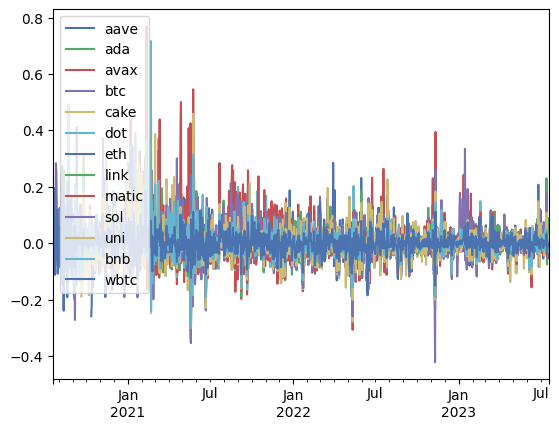

In [3]:
# this will give you the percentage change
df_percentage_variation = df.pct_change()

# plot variation of each asset's price
df_percentage_variation.plot()
pd.DataFrame(df).corr()

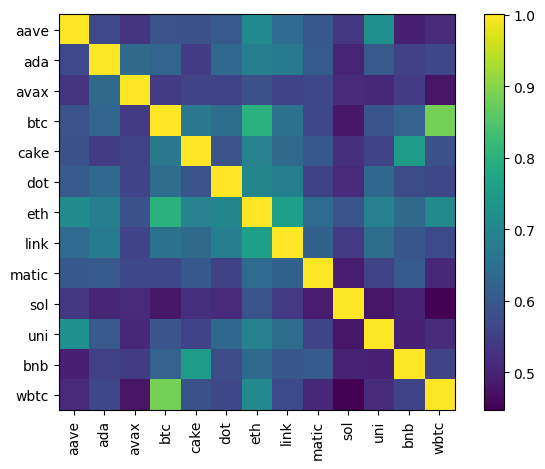

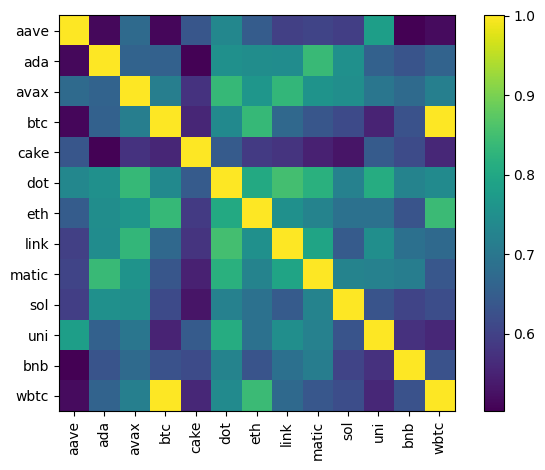

In [4]:
past_df, future_df = df.iloc[:-100], df.iloc[-100:]
future_cov = risk_models.sample_cov(future_df)
sample_cov = risk_models.sample_cov(past_df)

plotting.plot_covariance(sample_cov, plot_correlation=True)
plotting.plot_covariance(future_cov, plot_correlation=True)
plt.show()

In [5]:
rets = expected_returns(df)
rets.tail()

,aave,ada,avax,btc,cake,dot,eth,link,matic,sol,uni,bnb,wbtc
2023-07-16,-0.026166,-0.008205,0.014730,-0.000653,-0.007426,-0.003540,-0.002284,-0.002753,-0.012299,0.026051,-0.008906,0.013656,-0.000554
2023-07-17,-0.026923,-0.033928,-0.036122,-0.001357,-0.022958,-0.021628,-0.003196,-0.043356,-0.036932,-0.000939,-0.012907,-0.032328,-0.001066
2023-07-18,-0.021101,-0.007530,0.009329,-0.003505,0.028434,-0.001936,-0.006370,0.089304,0.012690,-0.018232,0.034099,0.004686,-0.003804
2023-07-19,-0.042012,-0.018456,-0.044670,-0.010218,-0.025269,-0.022891,-0.007785,-0.039419,-0.053164,-0.050761,-0.004085,-0.016682,-0.009499
2023-07-20,-0.003851,0.053785,0.016517,0.002590,0.004108,0.003642,-0.004155,-0.001351,0.010089,0.034707,-0.002700,0.004531,0.001821


In [6]:
# exp_cov = risk_models.exp_cov(past_df)
# plotting.plot_covariance(exp_cov, plot_correlation=True)
# plotting.plot_covariance(future_cov, plot_correlation=True)
# plt.show()

HRP Optimization
================

In [7]:
from portfolio_optimization.optimization.hrp import HRPOptimization

hrp = HRPOptimization(df, rets=rets)
hrp_weights = hrp.get_weights()
hrp_weights

aave     0.04624
ada      0.11106
avax     0.04216
btc      0.15619
cake     0.06324
dot      0.05464
eth      0.08845
link     0.05350
matic    0.03914
sol      0.06270
uni      0.04958
bnb      0.11349
wbtc     0.11962
dtype: float64

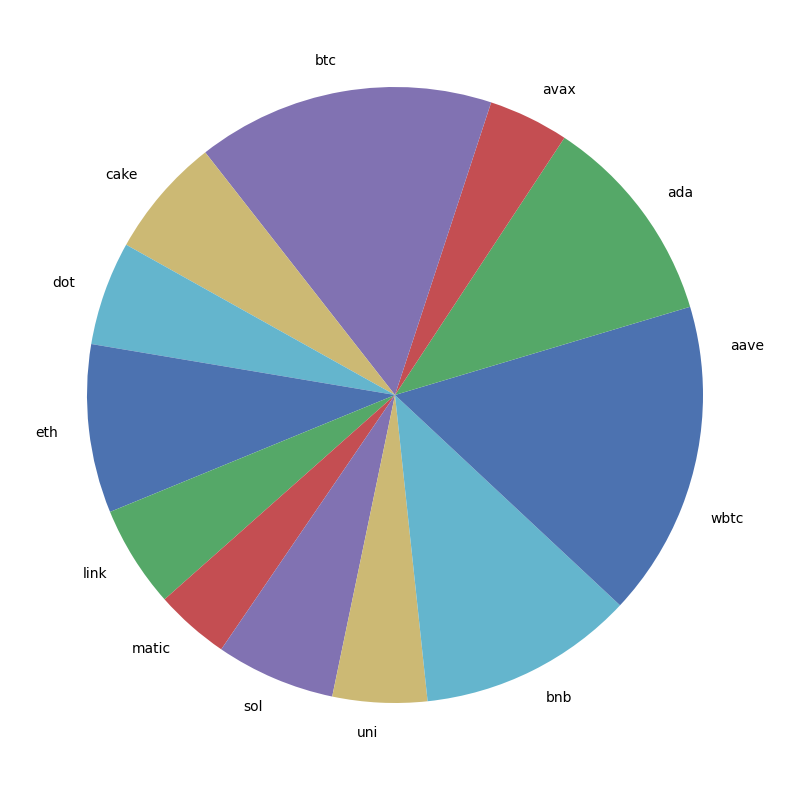

In [8]:
pd.Series(hrp_weights).plot.pie(figsize=(10, 10));

In [9]:
hrp.get_metrics()

{'apy': 0.6269642723802833,
 'annual_volatility': 0.6696185459167512,
 'sharpe_ratio': 0.9064328879202559}

# Markowitz optimization

/Users/arguiot/Developer/Pyratz/portfolio/portfolio_optimization/optimization/markowitz.py:124: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


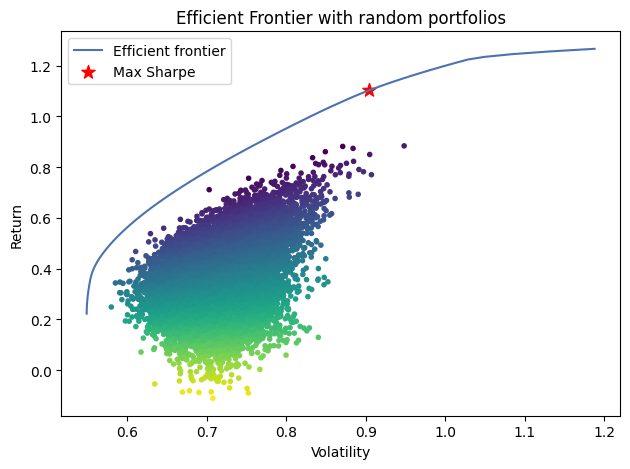

In [10]:
from portfolio_optimization.optimization.markowitz import Markowitz

markowitz = Markowitz(df)

markowitz_weights = markowitz.get_weights()
markowitz.plot_frontier()

aave     0.00000
ada      0.00000
avax     0.00000
btc      0.00000
cake     0.00000
dot      0.00000
eth      0.00000
link     0.00000
matic    0.38241
sol      0.32995
uni      0.00000
bnb      0.28764
wbtc     0.00000
dtype: float64


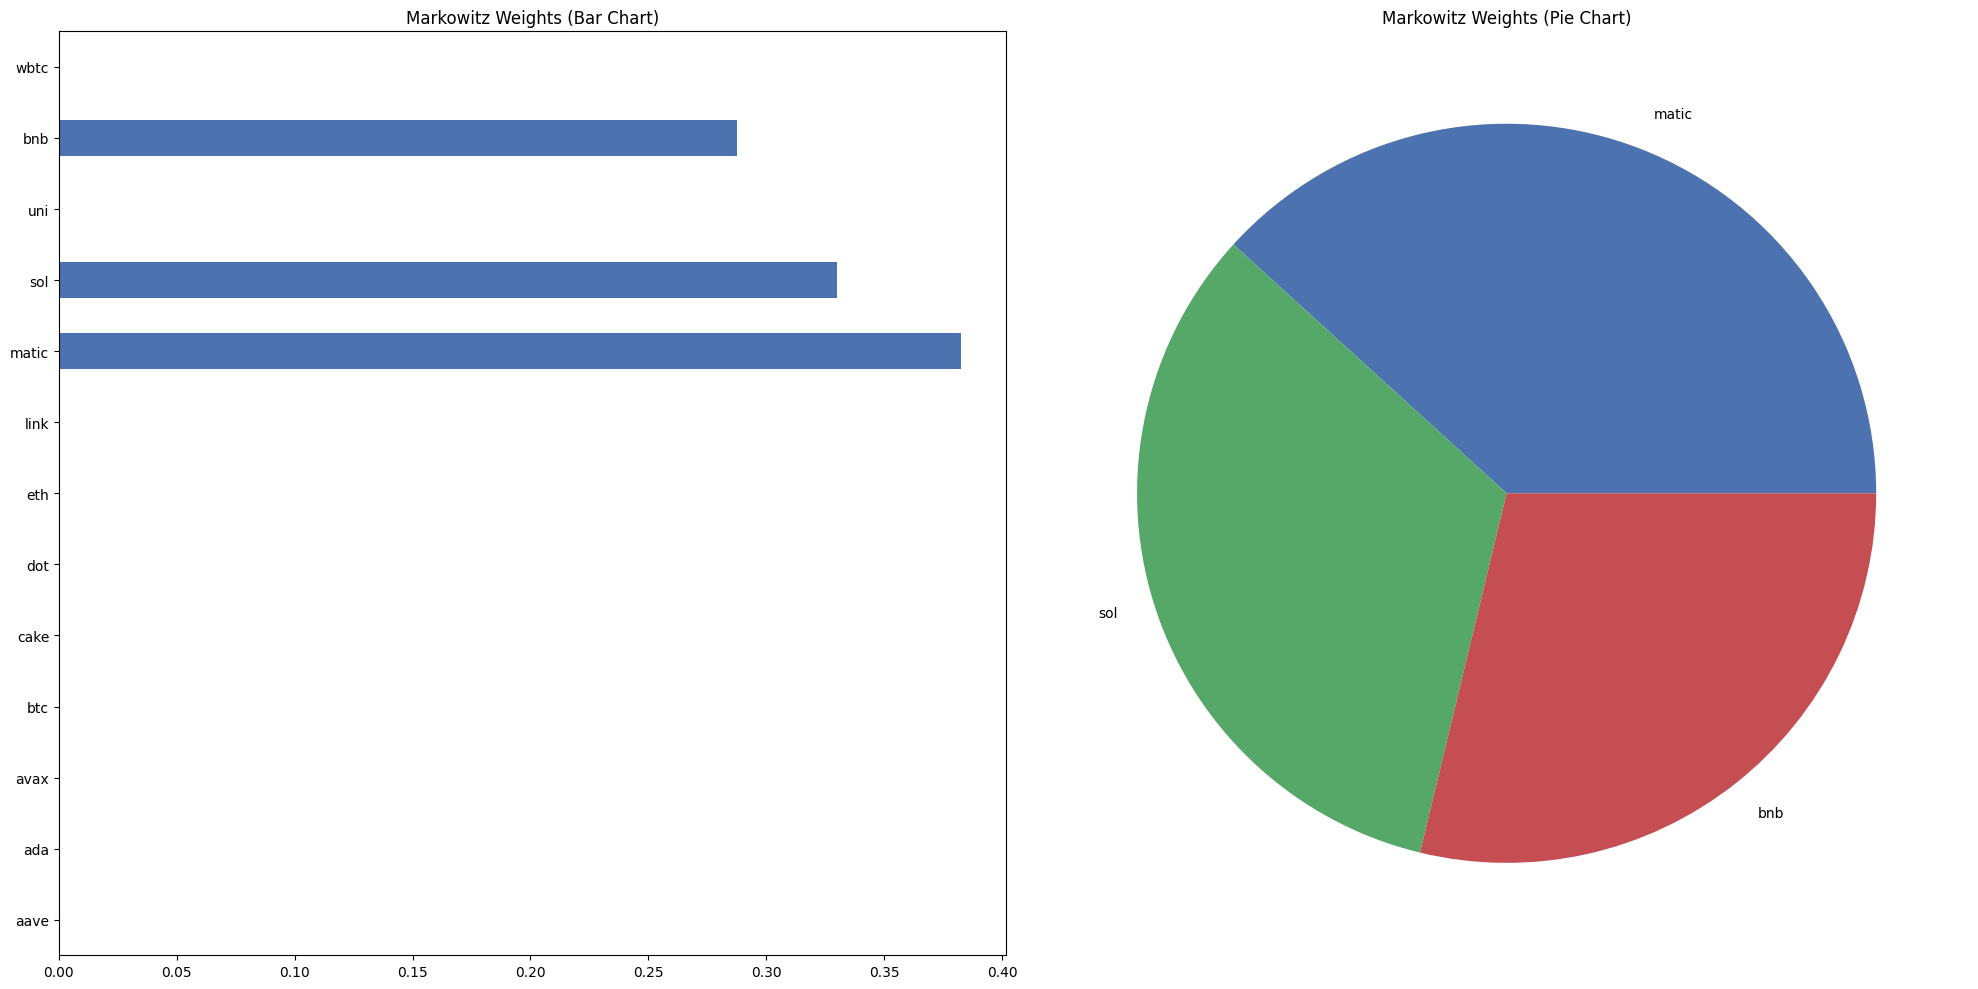

matic    0.38241
sol      0.32995
bnb      0.28764
dtype: float64

In [11]:
print(markowitz_weights)
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Bar chart on the left
pd.Series(markowitz_weights).plot(kind='barh', ax=axes[0], title="Markowitz Weights (Bar Chart)")

# Pie chart on the right without negative values
pd_weights = pd.Series(markowitz_weights)
positive_weights = pd_weights[pd_weights > 0]
positive_weights.plot(kind='pie', ax=axes[1], title="Markowitz Weights (Pie Chart)")

plt.tight_layout()
plt.show()
positive_weights

In [12]:
markowitz.get_metrics()

{'apy': 1.1028959268066463,
 'annual_volatility': 0.904435283145313,
 'sharpe_ratio': 1.197317206644912}

In [13]:
from portfolio_optimization.portfolio import weight_diff

diffs = weight_diff(markowitz_weights, hrp_weights, threshold=0.05)
print(len(diffs))
diffs

7


[('matic', 'Sell', 0.21873387071080386),
 ('sol', 'Sell', 0.1702934335871539),
 ('wbtc', 'Buy', 0.07622263994647466),
 ('ada', 'Buy', 0.07076815241979163),
 ('bnb', 'Sell', 0.11096950966960845),
 ('eth', 'Buy', 0.056360913754102016),
 ('btc', 'Buy', 0.09952528116736228)]

In [14]:
from portfolio_optimization.portfolio.Portfolio import Portfolio
from portfolio_optimization.backtesting.Backtesting import Backtest
from dateutil.relativedelta import relativedelta

start_date_portfolio = df.index[0] + relativedelta(months=5)

portfolio = Portfolio(
    weights=markowitz_weights,
    base_value=1000,
    initial_prices=df.loc[start_date_portfolio],
    optimiser=Markowitz,
)

backtest = Backtest(
    portfolio=portfolio,
    start_date=start_date_portfolio,
    end_date=df.index[-1],
    rebalance_frequency="2M",
    data=df,
)


portfolio_value, rebalance_dates, portfolio_compositions = backtest.run_backtest(look_back_period=5)
portfolio_value = portfolio_value.dropna()
portfolio_compositions = pd.DataFrame(portfolio_compositions).dropna()

at least one of the assets must have an expected return exceeding the risk-free rate
Skipping rebalance on 2022-04-30 due to insufficient data.
at least one of the assets must have an expected return exceeding the risk-free rate
Skipping rebalance on 2022-06-30 due to insufficient data.
at least one of the assets must have an expected return exceeding the risk-free rate
Skipping rebalance on 2022-08-31 due to insufficient data.
at least one of the assets must have an expected return exceeding the risk-free rate
Skipping rebalance on 2022-12-31 due to insufficient data.


In [15]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output
from ipywidgets import GridBox 

# Calculate the first date of the portfolio
start_date_portfolio = portfolio_value['Portfolio Value'].index.min()

# Normalize prices of each asset at the start date of the portfolio
df_normalized = df / df.loc[start_date_portfolio]

# Calculate the daily equal-weighted return  
df['equal_weighted'] = df_normalized.mean(axis=1)

# Normalize our portfolio and equally-weighted series to 100 at the start date of the portfolio
portfolio_normalized = 100 * portfolio_value['Portfolio Value'] / portfolio_value['Portfolio Value'].loc[start_date_portfolio]
equal_weighted_normalized = 100 * df['equal_weighted'] / df['equal_weighted'].loc[start_date_portfolio]

# Only consider the series after the portfolio start date
equal_weighted_normalized = equal_weighted_normalized[equal_weighted_normalized.index >= start_date_portfolio]
portfolio_normalized = portfolio_normalized[portfolio_normalized.index >= start_date_portfolio]

# convert the index to a list of dates, which will be used for the Slider
dates = portfolio_compositions.index.tolist()

# create a function to update the chart
def update(date_index):
    clear_output(wait=True)
        
    selected_date = dates[date_index]  
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # plot portfolio values on ax1
    ax1.plot(portfolio_normalized.index, portfolio_normalized, label='Portfolio')
    ax1.plot(equal_weighted_normalized.index, equal_weighted_normalized, label='Equal-Weighted Portfolio', color='red')
    
    for rebalance_date in rebalance_dates:
        if rebalance_date >= start_date_portfolio:
            ax1.axvline(x=rebalance_date, color='gray', linestyle='--')

    ax1.axvline(x=selected_date, color='blue', linestyle='-')  # the selected date bar

    ax1.set_xlabel("Date")
    ax1.set_ylabel("Normalized Value")
    ax1.legend()
    ax1.set_title("Performance comparison (selected blue line)")

    # create portfolio composition pie chart on ax2
    selected = portfolio_compositions.iloc[date_index][0]
    # filter out rows where value is 0
    selected = selected[selected != 0]

    labels = selected.keys().tolist()
    sizes = selected.tolist()

    ax2.pie(sizes, labels=labels)
    ax2.set_title(str(dates[date_index]))

    plt.show()

# create a slider for dates
date_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(dates)-1,
    step=1,
    description='Date Index:',
    continuous_update=True
)

# link the date_slider to the update function
widgets.interactive(update, date_index=date_slider)

interactive(children=(IntSlider(value=0, description='Date Index:', max=11), Output()), _dom_classes=('widget-…